# Portfolio Weighting Strategies

In this notebook, we explore several **portfolio weighting methods** commonly used in quantitative finance to construct optimal or diversified portfolios. The primary focus is on **how to assign weights to individual assets** based on their **risk, expected return, or a combination of both**. These weights ultimately determine how much capital is allocated to each asset in a portfolio.

---

##### Weighting Methods Covered

We implement three different weighting strategies in this notebook:

1. **Optimal Weights (`optimal_weights`)**
   - Derived from **mean-variance optimization**.  
   - Formula:  
     $$
     w^* = \frac{\Sigma^{-1} \mu}{\sum |\Sigma^{-1} \mu|}
     $$
   - Allocates capital to maximize **expected return relative to risk** given the covariance matrix (`sigma`) and expected returns (`mu`).

2. **Equal Volatility Weights (`eqvol_weights`)**
   - Each asset is scaled inversely to its **volatility**, creating a **risk-parity-like allocation**.
   - Formula:  
     $$
     w_i \propto \frac{1}{\sqrt{\sigma_{ii}}}
     $$
   - This method **balances risk contribution** rather than dollar exposure, giving **lower-volatility assets more weight**. More formally, we can define the normalsied form of the invese volatility weights formula (shown in the Pyhton code below) as follow:
     $$
     w_i = \frac{\frac{1}{\sqrt{\sigma_{ii}}}}{\sum{\frac{1}{\sqrt{\sigma_{ii}}}}}
     $$
3. **Sharpe Ratio Weights (`sr_weights`)**
   - Allocates capital proportionally to **expected return per unit of risk**.  
   - Formula:  
     $$
     w_i \propto \frac{\mu_i}{\sigma_{ii}}
     $$
   - Focuses on assets with **higher risk-adjusted returns**, ignoring correlations between assets.

---

*Additional Context*

- These functions use **numpy** for linear algebra and **pandas** for handling time series returns.  
- The notebook also includes a **synthetic return generator (`gen_strat_returns`)** to simulate a realistic asset universe with given **expected returns**, **volatilities**, and **correlations**.

We will start by **simulating asset returns**, then compute **weights for each method**, and finally evaluate the resulting portfolio characteristics. By the end of this section, you will be able to:

- Understand **different weighting approaches** and their rationale.
- Generate **synthetic multi-asset returns** for testing portfolio strategies.
- Compare **risk and return characteristics** of portfolios constructed using different weighting methods.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
# Let us define the functions for our different portfolio construction methods
def optimal_weights(sigma,mu):
  wgt = np.linalg.inv(sigma) @ mu 
  wgt = wgt / np.abs(wgt).sum()
  return wgt

def eqvol_weights(sigma):
  wgt = 1/np.sqrt(np.diag(sigma))
  wgt = wgt / np.abs(wgt).sum()
  return wgt

def sr_weights(sigma,mu):
  wgt = mu / np.diag(sigma) 
  wgt = wgt / np.abs(wgt).sum()
  return wgt

The function `gen_strat_returns()` simulates **synthetic daily returns** for a portfolio of three assets over a period of time. This is useful for **testing portfolio construction, risk management, and weighting strategies** without using real market data. Let us break it down step by step:

---

 1️⃣ Set Random Seed

```python
np.random.seed(5)
```
- Ensures reproducibility of random numbers.
- Every time you run the function, you’ll get the same simulated returns.

2️⃣ Define Correlation Matrix
```python
corr = [[1, 0.3, 0],
        [0.3, 1, 0],
        [0,   0, 1]]
corr = np.array(corr)
```
- Creates a 3x3 correlation matrix for three assets (A, B, C).
- Diagonal elements = 1 (an asset is perfectly correlated with itself).
- Off-diagonal elements = correlations between assets. For example:
  - Asset A & B = 0.3 (moderately correlated)
  - Asset A & C = 0 (uncorrelated)


3️⃣ Define Volatilities and Covariance Matrix
```python
vols = np.diag(np.array([0.1, 0.06, 0.02])) / np.sqrt(252)  # daily volatilities
sigma = vols @ corr @ vols  # covariance matrix
```
vols is a diagonal matrix containing the **annualized volatilities** of the assets, converted to **daily volatility** by dividing by $\sqrt{252}$.

The **covariance matrix** (`sigma`) is calculated as:

$$
\Sigma = D \cdot \text{Corr} \cdot D
$$

Where:

- $D$ = diagonal matrix of standard deviations (volatilities)
- $\text{Corr}$ = correlation matrix
- $\Sigma$ = covariance matrix (used for multivariate normal simulation)


4️⃣ Define Expected Daily Returns
```python
mu = np.array([0.1,0.12,0.04]) / 252  # daily expected returns
```
- Converts annual expected returns to daily expected returns by dividing by 252 trading days.
- Example: Asset A has an annual return of 10% → daily return ≈ 0.000397


5️⃣ Define Dates
```python
dates = pd.date_range('20100101','20191231',freq='B')
```
- Generates a business-day index from January 1, 2010, to December 31, 2019.
- Frequency B ensures only trading days are included.


6️⃣ Generate Correlated Returns

To generate correlated asset returns, we use the **multivariate normal distribution**:

$$
\mathbf{R} \sim \mathcal{N}(\boldsymbol{\mu}, \Sigma)
$$

Where:

- $\mathbf{R} = [R_1, R_2, \dots, R_n]^T$ is the vector of asset returns at a given time step  
- $\boldsymbol{\mu} = [\mu_1, \mu_2, \dots, \mu_n]^T$ is the **expected returns vector**  
- $\Sigma$ is the **covariance matrix** derived from volatilities and correlations

---

##### How the simulation works

1. Each simulated return vector $\mathbf{R}_t$  is drawn such that:

   - $\mathbb{E}[\mathbf{R}_t] = \boldsymbol{\mu}$  
   - $\text{Cov}(\mathbf{R}_t) = \Sigma$


```python
rets = np.random.multivariate_normal(mu, sigma, size=len(dates))
rets = pd.DataFrame(rets, columns=['A','B','C'], index=dates)
```
- Uses the multivariate normal distribution to generate daily returns that:
  - Have the specified mean vector mu
  - Have the specified covariance sigma
- Converts the results into a pandas DataFrame for easy analysis, with assets as columns and dates as the index.

In [3]:
# This function generates correlated returns for 3 assets A, B and C. For simplicity, we will define the values
# in the function itself
def gen_strat_returns():
  np.random.seed(5)
  
  # Step 1: Define our correlation matrix and convert it to a numpy array
  corr = [[1, 0.3, 0],
          [0.3, 1, 0],
          [0,   0, 1]]
  corr = np.array(corr)
  
  # Step 2: Define our volatilities and convert it to a covariance matrix: sigma = D @ corr @ D
  vols = np.diag(np.array([0.1, 0.06, 0.02])) / np.sqrt(252) # daily vols of our 3 assets
  
  sigma = vols @ corr @ vols # covariance matrix
  
  mu = np.array([0.1,0.12,0.04]) / 252 # daily expected returns of our 3 assets
  
  dates = pd.date_range('20100101','20191231',freq='B') # business days from 2010 to 2019
  
  # Step 3: Generate correlated returns using multivariate normal distribution
  rets = np.random.multivariate_normal(mu, sigma, size = len(dates))
  rets = pd.DataFrame(rets,columns = ['A','B','C'], index = dates)
  return rets

Now that we have our fcuntions, let us first generate the strategy returns of our 3 assets

In [4]:
rets = gen_strat_returns()
rets

,A,B,C
2010-01-01,-0.002059,-0.001372,0.003221
2010-01-04,0.001871,0.001262,0.002152
2010-01-05,0.006595,-0.000055,0.000395
2010-01-06,0.003519,-0.003050,-0.000099
2010-01-07,0.002096,0.003119,-0.001939
...,...,...,...
2019-12-25,-0.008275,-0.004177,0.000527
2019-12-26,0.005651,-0.002126,0.000724
2019-12-27,-0.005615,0.002277,0.003227
2019-12-30,0.000157,-0.003438,0.000166


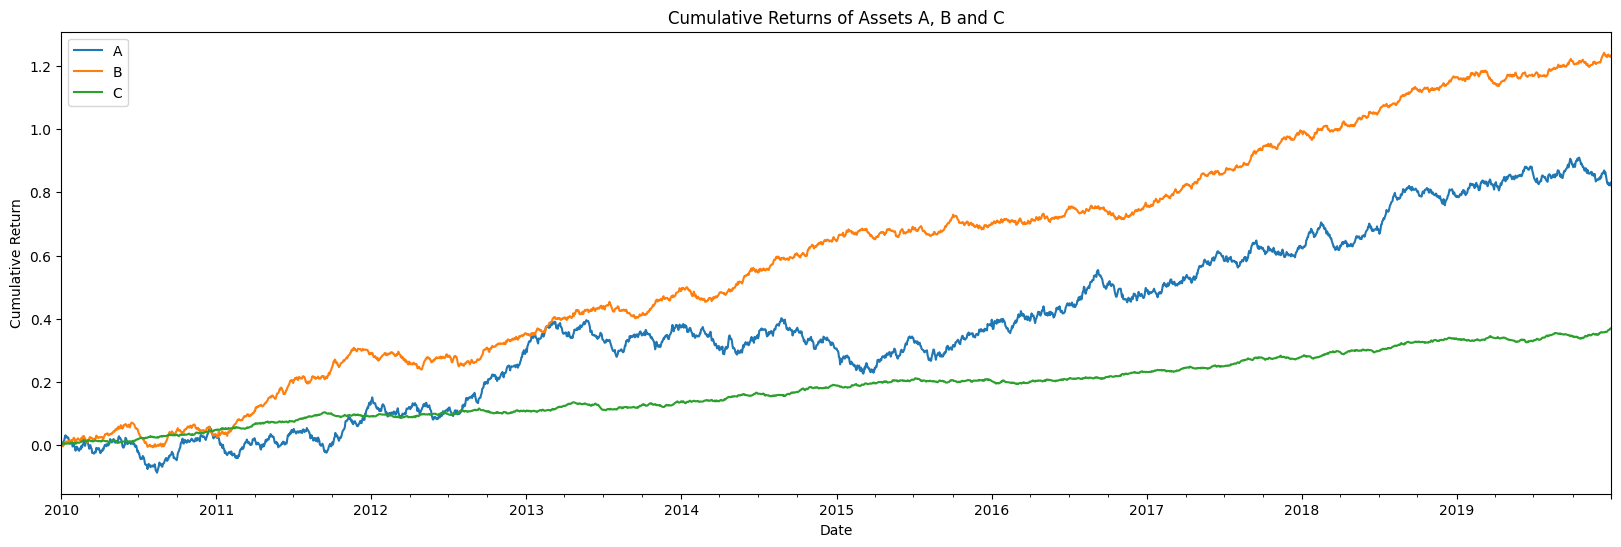

In [5]:
# Let us first plot the cumulative returns of our 3 assets
rets.cumsum().plot()
plt.title("Cumulative Returns of Assets A, B and C")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.gcf().set_size_inches(20, 6) # Increase the size of the plot for better visibility
plt.show()

📊 Annualized Portfolio Statistics

The code below calculates **key performance metrics** for the simulated asset returns:

In [6]:
stats = {}
stats['ret'] = rets.mean()*252
stats['vol'] = rets.std()*np.sqrt(252)
stats['SR'] = rets.mean() / rets.std()*np.sqrt(252)
stats = pd.DataFrame(stats)
stats

,ret,vol,SR
A,0.080349,0.099250,0.809560
B,0.119119,0.059490,2.002332
C,0.035777,0.020361,1.757164


Calculate the covariance, correlation and mean of our assets

In [7]:
sigma = rets.cov()
sigma 

,A,B,C
A,3.908957e-05,6.981310e-06,-2.034364e-07
B,6.981310e-06,1.404386e-05,3.448106e-09
C,-2.034364e-07,3.448106e-09,1.645099e-06


In [8]:
corr = rets.corr()
corr

,A,B,C
A,1.000000,0.297964,-0.025369
B,0.297964,1.000000,0.000717
C,-0.025369,0.000717,1.000000


In [9]:
mu = rets.mean()
mu

A    0.000319
B    0.000473
C    0.000142
dtype: float64

This section calculates **portfolio weights** for each of the three strategies we implemented: **Optimal, Equal-Volatility, and Sharpe Ratio-based weights**.

In [10]:
weights = {}
weights['opt'] = optimal_weights(sigma,mu)
weights['eqvol'] = eqvol_weights(sigma)
weights['sr'] = sr_weights(sigma,mu)
weights = pd.DataFrame(weights)
weights.round(2)

,opt,eqvol,sr
A,0.02,0.13,0.06
B,0.26,0.22,0.26
C,0.71,0.65,0.67


This section calculates the **combined portfolio returns** for each weighting strategy and evaluates their **annualized Sharpe Ratios**.

In [11]:
combo_rets={}
combo_rets['opt'] = (rets*weights['opt']).sum(1)
combo_rets['eqvol'] = (rets*weights['eqvol']).sum(1)
combo_rets['sr'] = (rets*weights['sr']).sum(1)
combo_rets = pd.DataFrame(combo_rets)
combo_sr = combo_rets.mean() / combo_rets.std() * np.sqrt(252)
combo_sr

opt      2.676739
eqvol    2.426157
sr       2.635691
dtype: float64

With the 3 different weighting methods covered, let us compute and plot the returns for each of these portfolios, and contrast them with the individual assets of A, B and C

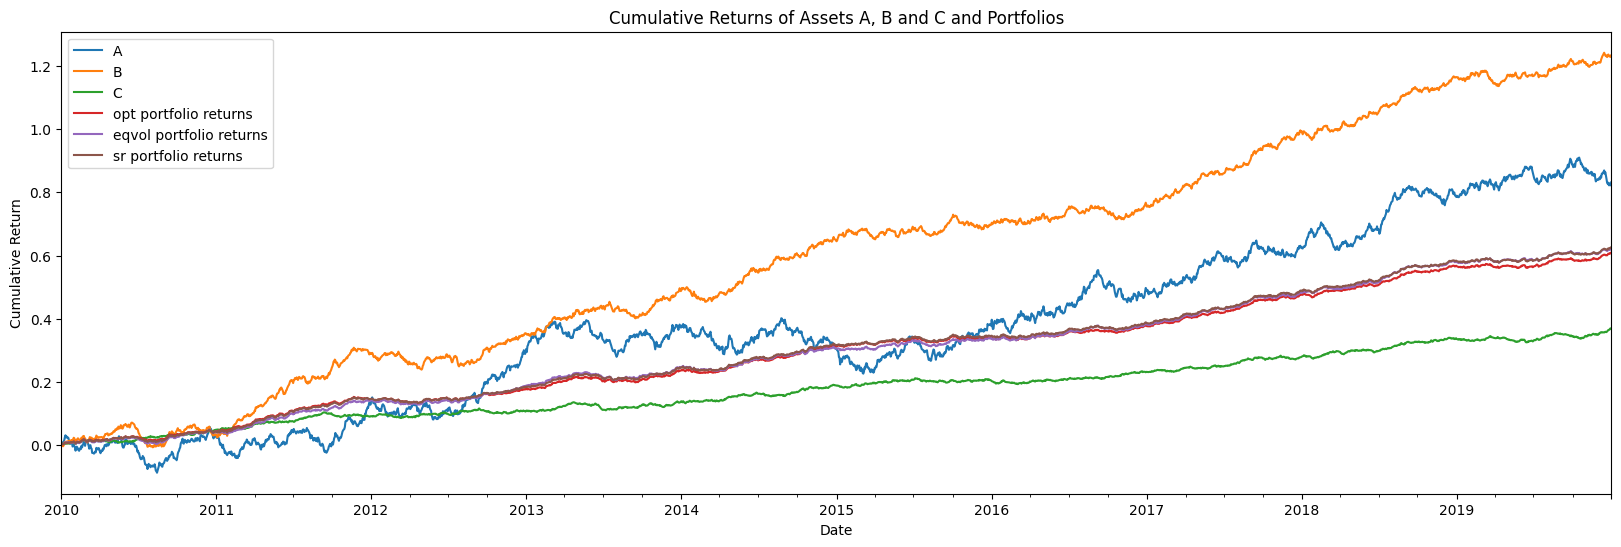

In [18]:
combined_rets = rets.copy()

# Dot product the returns of each asset by their respective weights to get the portfolio returns for each period and add them as new columns
for col in weights.columns:
  combined_rets[f'{col} portfolio returns'] = (combined_rets * weights[col]).sum(axis=1)

# Plot all the cumulative returns together
combined_rets.cumsum().plot()
plt.title("Cumulative Returns of Assets A, B and C and Portfolios")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.gcf().set_size_inches(20, 6) # Increase the size of the plot for better visibility
plt.show()

In this section, we demonstrate **scaling the portfolio weights** to adjust the overall exposure of the portfolio.

1. Scaling Weights
- weights['opt'] * constant multiplies all optimal portfolio weights by a factor of 5.
- This increases the overall leverage/exposure of the portfolio while keeping the relative allocations the same.

2. Compute Portfolio Returns
- (rets * (weights['opt'] * constant)).sum(1) computes the daily portfolio returns after scaling.
- Summing across columns aggregates the returns of all assets based on their scaled weights.

3. Annualized Sharpe Ratio
- scaled.mean() / scaled.std() * np.sqrt(252) calculates the risk-adjusted return of the scaled portfolio.
- Scaling increases both expected return and volatility, so the Sharpe ratio may or may not change significantly, depending on the correlation and variance structure.

In [12]:
constant = 5
scaled = (rets*(weights['opt']*constant)).sum(1) # Scale optimal weights by a factor of 5
scaled.mean()/scaled.std()*np.sqrt(252) # Annualized Sharpe Ratio

2.6767391373599727

As you can see, our scaled portfolio's SR is the same as the unscaled one, thus illustrating the fact that leverage only amplifies the return and not the Sharpe